In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tcr
%matplotlib inline
import seaborn as sns
import emoji
import string
import nltk
nltk.download('stopwords') #needed to download the stopwords first before importing
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from fast_ml.model_development import train_valid_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
import time
from matplotlib.colors import LinearSegmentedColormap

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/amybirdee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data import

In [2]:
#data import
reviews = pd.read_csv('/home/amybirdee/hobby_projects/bumble_app_reviews/bumble_google_play_reviews.csv')

In [3]:
#review data
pd.set_option('max_colwidth', 30)
reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOGCWX1s8NNKNYQ5uMK...,Javed Sahiad,https://play-lh.googleuser...,Bumble rocks 👍🤞,5,0,5.253.0,28/03/2022 23:33,NaN,NaN
1,gp:AOqpTOFmBlHJLKFu87RU2d-...,Justin Miller,https://play-lh.googleuser...,Just a cash grab. Congrats...,1,0,5.262.0,28/03/2022 23:23,NaN,NaN
2,gp:AOqpTOHAcFeMyfgGN_6k7HR...,Adam Poots,https://play-lh.googleuser...,"Terrible, l have lost tota...",1,15,5.260.0,28/03/2022 23:10,Uh oh! We'll need some mor...,23/02/2022 12:33
3,gp:AOqpTOEinp2G2V2iYesrwB6...,Jonnalyn Gonzales,https://play-lh.googleuser...,Easy to use,5,0,5.261.1,28/03/2022 22:28,NaN,NaN
4,gp:AOqpTOG4ElAfNPCFwqm-WSR...,Stetson&Spurs,https://play-lh.googleuser...,"Just alot of gimmicks, fak...",1,0,5.262.0,28/03/2022 22:20,NaN,NaN


## Data exploration and pre-processing

In [4]:
#check shape pf dataframe - 10 columns, 105,438 rows
reviews.shape

(105438, 10)

In [5]:
#check data types - data types are correct. There are some missing values in the review created version and reply columns
#but we won't need these for the sentiment analysis and will therefore drop them rather than fill them
#there are also null values in the contents column - we will drop those rows as we won't be able to predict anything for them
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105438 entries, 0 to 105437
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              105438 non-null  object
 1   userName              105438 non-null  object
 2   userImage             105438 non-null  object
 3   content               105434 non-null  object
 4   score                 105438 non-null  int64 
 5   thumbsUpCount         105438 non-null  int64 
 6   reviewCreatedVersion  88667 non-null   object
 7   at                    105438 non-null  object
 8   replyContent          61241 non-null   object
 9   repliedAt             61241 non-null   object
dtypes: int64(2), object(8)
memory usage: 8.0+ MB


In [6]:
#checking dataframe summary
reviews.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
reviewId,105438,105438,gp:AOqpTOFuI4t0DSGHl0ChWBu...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userName,105438,95284,A Google user,4746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userImage,105438,100694,https://play-lh.googleuser...,4745,NaN,NaN,NaN,NaN,NaN,NaN,NaN
content,105434,91048,Good,1255,NaN,NaN,NaN,NaN,NaN,NaN,NaN
score,105438,NaN,NaN,NaN,2.82928,1.7192,1,1,3,5,5
thumbsUpCount,105438,NaN,NaN,NaN,2.73753,18.0899,0,0,0,1,1275
reviewCreatedVersion,88667,369,1.15.0,1659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
at,105438,102652,23/04/2019 10:40,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
replyContent,61241,34418,We're sorry you didn't enj...,1489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
repliedAt,61241,46108,21/04/2017 08:42,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Average score is 2.8
* Unique user names are circa 95,000 whereas total reviews are circa 105,000 indicating that some users have given
multiple reviews

In [7]:
#we only need the review content and the score information for the analysis so we will drop all other columns
reviews = reviews.drop(['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', \
                       'repliedAt'], axis = 1)

In [8]:
#dropping null values in content column
reviews = reviews.dropna(subset = ['content']).reset_index(drop = True)

In [9]:
#no null values in remaining columns
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105434 entries, 0 to 105433
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  105434 non-null  object
 1   score    105434 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


In [10]:
#increase the column size so we can read the reviews properly
pd.set_option('max_colwidth', 800)

In [11]:
#view updated dataframe
reviews.head()

,content,score
0,Bumble rocks 👍🤞,5
1,"Just a cash grab. Congrats you have 2 new likes! Here we'll let you swipe right until you find them. Oh no, you're out of likes, but don't worry we'll let you buy more for $19 a month.",1
2,"Terrible, l have lost total faith in this app, promised to contact me but have never came back since start of Feb, shame on this app. Worst ever",1
3,Easy to use,5
4,"Just alot of gimmicks, fake profile, and upsales. Oh and if you decide to delete your account and leave a negative review, they block your email, or phone number from re-registering in the future lol.",1


# Data visualisation

In [12]:
#grouping scores to create a chart
aggregate_scores = reviews.groupby('score').size().to_frame().reset_index().rename(columns = {0: 'counts'})
aggregate_scores

,score,counts
0,1,41874
1,2,9857
2,3,8969
3,4,13864
4,5,30870


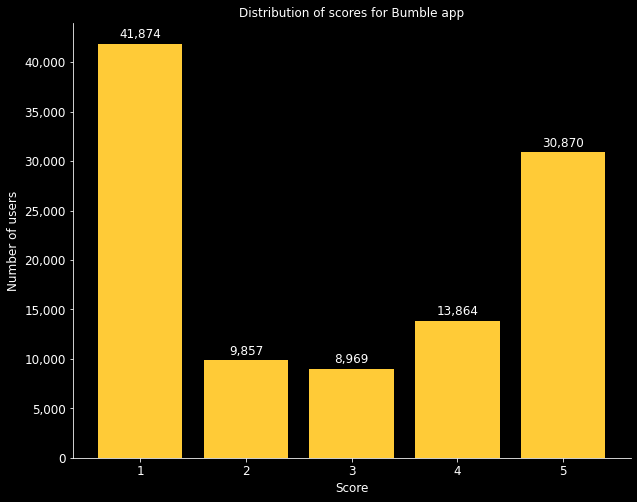

In [13]:
#create chart to visualise distribution of scores
fig = plt.figure(figsize = (10, 8))
fig.set_facecolor('black')
ax = plt.subplot()

plt.bar(aggregate_scores.score, aggregate_scores.counts, color = '#FFCB37')

#removing chart borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#setting remaining borders to white colour
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

#define a function to add comma separator to labels. Function takes tick label and tick position
def comma(x_label, position):
    return format(x_label, ",.0f")

#define a variable which will be used in the second function below
bars = plt.bar(aggregate_scores.score, aggregate_scores.counts, color = '#FFCB37')

#define a function that will add labelse to the bars and format them correctly
def chart_labels(ax):
    for bar in bars:
        yval = bar.get_height()
        #the '{:,}' command adds a thousand separator to the labels
        ax.annotate('{:,}'.format(yval),
        xy = (bar.get_x() + bar.get_width() / 2, yval),
        #shows label position on x and y axis
        xytext = (0, 3),
        textcoords = 'offset points', ha = 'center', va = 'bottom', fontsize = 12, color = 'white')
        
#call the function to format the y axis labels
ax.yaxis.set_major_formatter(tcr.FuncFormatter(comma))

#call the function to format chart labels
chart_labels(ax)

plt.xticks(aggregate_scores.score, fontsize = 12, color = 'white')
plt.xlabel('Score', fontsize = 12, color = 'white')
plt.ylabel('Number of users', fontsize = 12, color = 'white')
ax.tick_params(colors = 'white', which = 'both', labelsize = 12)
ax.patch.set_alpha(0.0)
plt.title('Distribution of scores for Bumble app', fontsize = 12, color = 'white')
plt.savefig('score_distribution')

# Feature engineering

In [14]:
#we will bucket the reviews into three groups - 1 and 2 are negative reviews, 3 is neutral, 4 and 5 are positive reviews
#create a function that will apply the sentiment values based on the numbers
def review_sentiment(row):
    if row['score'] == 1:
        value = 'Negative'
    elif row['score'] == 2:
        value = 'Negative'
    elif row['score'] == 4:
        value = 'Positive'
    elif row['score'] == 5:
        value = 'Positive'
    else:
        value = 'Neutral'
    return value

In [15]:
#apply function to the dataframe
reviews['review_sentiment'] = reviews.apply(review_sentiment, axis = 1)
reviews.head()

,content,score,review_sentiment
0,Bumble rocks 👍🤞,5,Positive
1,"Just a cash grab. Congrats you have 2 new likes! Here we'll let you swipe right until you find them. Oh no, you're out of likes, but don't worry we'll let you buy more for $19 a month.",1,Negative
2,"Terrible, l have lost total faith in this app, promised to contact me but have never came back since start of Feb, shame on this app. Worst ever",1,Negative
3,Easy to use,5,Positive
4,"Just alot of gimmicks, fake profile, and upsales. Oh and if you decide to delete your account and leave a negative review, they block your email, or phone number from re-registering in the future lol.",1,Negative


In [16]:
#drop the score column
reviews = reviews.drop(['score'], axis = 1)

In [17]:
#recreate above chart but now using review sentiment column to see how the distribution has changed
#first group the data
sentiment = reviews.groupby('review_sentiment').size().to_frame().reset_index().rename(columns = {0: 'counts'})
sentiment

,review_sentiment,counts
0,Negative,51731
1,Neutral,8969
2,Positive,44734


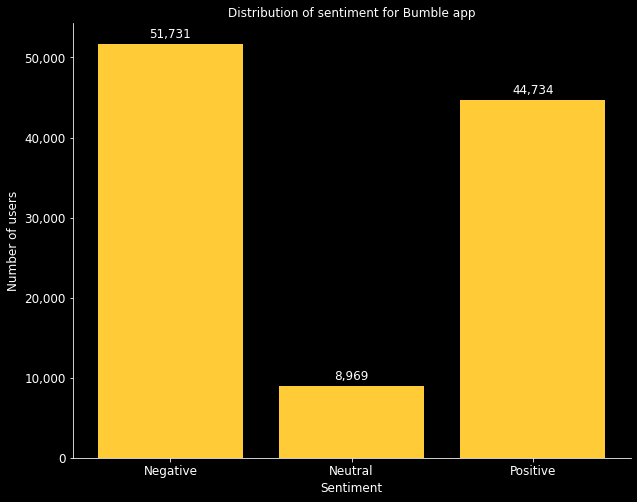

In [18]:
#create chart
fig = plt.figure(figsize = (10, 8))
fig.set_facecolor('black')
ax = plt.subplot()

plt.bar(sentiment.review_sentiment, sentiment.counts, color = '#FFCB37')

#removing chart borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#setting remaining borders to white colour
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

#define a variable which will be used in the chart labels function
bars = plt.bar(sentiment.review_sentiment, sentiment.counts, color = '#FFCB37')
        
#call the function to format the y axis labels
ax.yaxis.set_major_formatter(tcr.FuncFormatter(comma))

#call the function to format chart labels
chart_labels(ax)

plt.xticks(sentiment.review_sentiment, fontsize = 12, color = 'white')
plt.xlabel('Sentiment', fontsize = 12, color = 'white')
plt.ylabel('Number of users', fontsize = 12, color = 'white')
ax.tick_params(colors = 'white', which = 'both', labelsize = 12)
ax.patch.set_alpha(0.0)
plt.title('Distribution of sentiment for Bumble app', fontsize = 12, color = 'white')
plt.savefig('sentiment_distribution')


# Text processing - emojis

In [19]:
#since I'm processing the data now, I'll create a new dataframe so that the orginal reviews are still stored in the 
#reviews dataframe
reviews_processed = reviews[['content', 'review_sentiment']]
reviews_processed.head()

,content,review_sentiment
0,Bumble rocks 👍🤞,Positive
1,"Just a cash grab. Congrats you have 2 new likes! Here we'll let you swipe right until you find them. Oh no, you're out of likes, but don't worry we'll let you buy more for $19 a month.",Negative
2,"Terrible, l have lost total faith in this app, promised to contact me but have never came back since start of Feb, shame on this app. Worst ever",Negative
3,Easy to use,Positive
4,"Just alot of gimmicks, fake profile, and upsales. Oh and if you decide to delete your account and leave a negative review, they block your email, or phone number from re-registering in the future lol.",Negative


In [20]:
#dataframe contains emojis which the model won't understand. Creating function to convert emojis to text
def remove_emoji(data):
    return emoji.demojize(data)

In [21]:
#apply the function to the data frame and create a new column
reviews_processed['content_new'] = reviews_processed['content'].apply(remove_emoji)

In [22]:
#function has worked as expected and content_new column contains text in place of the emoji
reviews_processed.head()

,content,review_sentiment,content_new
0,Bumble rocks 👍🤞,Positive,Bumble rocks :thumbs_up::crossed_fingers:
1,"Just a cash grab. Congrats you have 2 new likes! Here we'll let you swipe right until you find them. Oh no, you're out of likes, but don't worry we'll let you buy more for $19 a month.",Negative,"Just a cash grab. Congrats you have 2 new likes! Here we'll let you swipe right until you find them. Oh no, you're out of likes, but don't worry we'll let you buy more for $19 a month."
2,"Terrible, l have lost total faith in this app, promised to contact me but have never came back since start of Feb, shame on this app. Worst ever",Negative,"Terrible, l have lost total faith in this app, promised to contact me but have never came back since start of Feb, shame on this app. Worst ever"
3,Easy to use,Positive,Easy to use
4,"Just alot of gimmicks, fake profile, and upsales. Oh and if you decide to delete your account and leave a negative review, they block your email, or phone number from re-registering in the future lol.",Negative,"Just alot of gimmicks, fake profile, and upsales. Oh and if you decide to delete your account and leave a negative review, they block your email, or phone number from re-registering in the future lol."


In [23]:
#can now drop the original content column and will also move the sentiment column to the end
reviews_processed = reviews_processed.drop(['content'], axis = 1)
reviews_processed = reviews_processed[['content_new', 'review_sentiment']]
reviews_processed.head()

,content_new,review_sentiment
0,Bumble rocks :thumbs_up::crossed_fingers:,Positive
1,"Just a cash grab. Congrats you have 2 new likes! Here we'll let you swipe right until you find them. Oh no, you're out of likes, but don't worry we'll let you buy more for $19 a month.",Negative
2,"Terrible, l have lost total faith in this app, promised to contact me but have never came back since start of Feb, shame on this app. Worst ever",Negative
3,Easy to use,Positive
4,"Just alot of gimmicks, fake profile, and upsales. Oh and if you decide to delete your account and leave a negative review, they block your email, or phone number from re-registering in the future lol.",Negative


In [24]:
#removal of emojis has resulted in consecutive colons placed where there are two consective emojis - replacing these with
#a space so that the words aren't combined when we remove punctuation in the next step
reviews_processed['content_new'] = reviews_processed['content_new'].str.replace('::', ' ')
reviews_processed.head()

,content_new,review_sentiment
0,Bumble rocks :thumbs_up crossed_fingers:,Positive
1,"Just a cash grab. Congrats you have 2 new likes! Here we'll let you swipe right until you find them. Oh no, you're out of likes, but don't worry we'll let you buy more for $19 a month.",Negative
2,"Terrible, l have lost total faith in this app, promised to contact me but have never came back since start of Feb, shame on this app. Worst ever",Negative
3,Easy to use,Positive
4,"Just alot of gimmicks, fake profile, and upsales. Oh and if you decide to delete your account and leave a negative review, they block your email, or phone number from re-registering in the future lol.",Negative


# Text processing - punctuation, stop words, stemming, lower case

In [25]:
#will need to remove stop words. First creating a list of these
stop = stopwords.words('english')
print(stop[0:11])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've"]


In [26]:
#create function to remove stopwords
def remove_stopwords(review):
    review = ' '.join([word for word in review.split(' ') if word not in stop])
    return review

In [27]:
#create function that will remove punctuation from review content
#string.punctuation includes a list of all punctuation
#maketrans takes three arguments - the string to be replaced, the string to replace with, the string to delete

def remove_punctuation(review):
    return review.translate(str.maketrans('', '', string.punctuation))

In [28]:
#create function to make all letters lower case
def lower_case(review):
    return review.lower()

In [29]:
#apply the functions - will also apply a function to stem the words - will use Snowball Stemmer as this is a more
#advanced version of porter stemmer

snow_stemmer = SnowballStemmer(language = 'english')
reviews_processed['content_new'] = reviews_processed['content_new'].apply(snow_stemmer.stem)

reviews_processed['content_new'] = reviews_processed['content_new'].apply(remove_stopwords)
reviews_processed['content_new'] = reviews_processed['content_new'].apply(remove_punctuation)
reviews_processed['content_new'] = reviews_processed['content_new'].apply(lower_case)
reviews_processed.head()

,content_new,review_sentiment
0,bumble rocks thumbsup crossedfingers,Positive
1,cash grab congrats 2 new likes well let swipe right find them oh no likes worry well let buy 19 month,Negative
2,terrible l lost total faith app promised contact never came back since start feb shame app worst ev,Negative
3,easy us,Positive
4,alot gimmicks fake profile upsales oh decide delete account leave negative review block email phone number reregistering future lol,Negative


In [30]:
#view a sample of the dataframe to check all the functions have been applied correctly - some words have been over stemmed
#but generally all functions seem to have been applied as expected
reviews_processed.sample(n = 10)

,content_new,review_sentiment
77430,distance app setting clearly work keep getting guys 4050 miles away,Negative
7537,use 1 month one match bad application dating,Negative
52940,great wish us guys message someth,Positive
12029,autosubscription billing hard perceive cancellation menu update commented explanation bumble even closely react critical view still stays same way cancellation possible hidden user hard find seems much purpose,Negative
85090,lot better thought would be,Positive
38445,tried months joke idea women engaging men first fantasy unrealistic switched focus finding platonic friends networking professionals kidding supposed dating app linkedin facebook every woman know whos used it used platonic female friends women look like supermodels know theyre fake af antidating disguised dating suck money you,Negative
91283,let edit profile created account pulled random pictures facebook allow change anything els,Negative
95880,matches dont even send message basically tool hot chicks get self reassurance hot,Neutral
24779,sexist app initial likes ran day day kept saying likes day never refilled them,Negative
50574,amazing featur,Positive


# Feature pre-processing for model

In [31]:
#the model won't be able to read the review content or the sentiment so I will use Tfidf to tokenise the reviews and add
#numerical labels for the sentiment column

#Tfidf returns an encoded vector with a weighted count for each word. It emphasises the rarity of the word by comparing the 
#word in the document (review) to the whole corpus (dataframe). This means we can identify frequent terms within each
#document that are not so frequent in the whole corpus

#Tfidf weighs down terms that appear frequently and scales up more unique terms
#TF = term frequency (how often the term occurs)
#IDF = inverse document frequency (how important the term is)

In [32]:
#some hyperparameters in the tfidf vectorizer include:

#min_df: used to remove items that appear too infrequently, e.g. if min_df = 5, the vectorizer will ignore terms that
#appear in less than 5 the documents (reviews). Can also use proportions rather than numbers, e.g. 0.05 will mean items
#that appear in less than 5% of documents will be ignored

#max_df: used to remove items that appear too frequently - also known as 'corpus specific stop words'. E.g. is max_df = 25,
#the vectorizer will ignore terms that appear in more than 25 documents. Can also use proportions as above

#ngram_range: ngrams can detect and maintain local ordering, e.g. if the document includes the terms 'bumble' and 'app'
#the ngram should be able to detect that these go together and read it is 'bumble app'. An ngram range of (1, 1) means
#only unigrams, (1, 2) means unigrams and bigrams and (2, 2) is just bigrams

#max_features: the user defines this as a number, e.g 65000. All the features (unigrams, bigrams etc) are ordered by 
#freqency in the entire corpus and the top 65000 are selected, the rest are excluded

In [33]:
#perform TFIDF transformation on content_new column. will set min_df to 5 as this should eliminate most typos, will include
#both unigrams and bigrams and set max_features to 50,000

tfidf_vect = TfidfVectorizer(max_features = 50000, min_df = 5, ngram_range = (1, 2), stop_words = 'english')
review_vector = tfidf_vect.fit_transform(reviews_processed['content_new'])

In [34]:
print('content shape: ' + str(review_vector.shape))

content shape: (105434, 34284)


In [35]:
#we can view how the tfidf vectorizer has weighted the words by creating a dictionary and mapping the tokens (words) to 
#their tfidf values

tfidf_dict = dict(zip(tfidf_vect.get_feature_names(), tfidf_vect.idf_))

tfidf_df = pd.DataFrame.from_dict(dict(tfidf_dict), orient = 'index')

tfidf_df.columns = ['tfidf_score']

tfidf_df.head()

,tfidf_score
010,9.233645
010 recommend,10.774090
05,9.387796
05 stars,10.774090
10,5.884995


In [36]:
#lowest tfidf scores
tfidf_df.sort_values(by = ['tfidf_score'], ascending = True).head(10)

,tfidf_score
app,2.024622
good,3.133647
like,3.205109
people,3.246207
great,3.499842
bumble,3.535474
matches,3.589335
time,3.628894
dating,3.658508
im,3.702093


In [37]:
#highest tfidf scores - top 1000 tokens all have the same score
tfidf_df.sort_values(by = ['tfidf_score'], ascending = False).head(10)

,tfidf_score
ill check,10.77409
got boyfriend,10.77409
users respond,10.77409
brilliant idea,10.77409
matches spending,10.77409
weeded,10.77409
exiting,10.77409
try trick,10.77409
matches straight,10.77409
definitely different,10.77409


In [38]:
#now create labels for sentiment column
#syntax for np.where statement is (filter value, new value, column name)

reviews_processed['review_sentiment'] = np.where(reviews_processed['review_sentiment'] == 'Negative', 0, \
                                                 reviews_processed['review_sentiment'])
reviews_processed['review_sentiment'] = np.where(reviews_processed['review_sentiment'] == 'Neutral', 1, \
                                                reviews_processed['review_sentiment'])
reviews_processed['review_sentiment'] = np.where(reviews_processed['review_sentiment'] == 'Positive', 2, \
                                                reviews_processed['review_sentiment'])
reviews_processed.head()

,content_new,review_sentiment
0,bumble rocks thumbsup crossedfingers,2
1,cash grab congrats 2 new likes well let swipe right find them oh no likes worry well let buy 19 month,0
2,terrible l lost total faith app promised contact never came back since start feb shame app worst ev,0
3,easy us,2
4,alot gimmicks fake profile upsales oh decide delete account leave negative review block email phone number reregistering future lol,0


In [39]:
#putting the new column into its own dataframe
sentiment_label = reviews_processed[['review_sentiment']]
sentiment_label.head()

,review_sentiment
0,2
1,0
2,0
3,2
4,0


In [40]:
#converting the sparse matrix to a sparse dataframe so that this can be merged with the newly labelled review_sentiment
#column
reviews_df = pd.DataFrame.sparse.from_spmatrix(review_vector)
reviews_df.head()

,0,1,2,3,4,5,6,7,8,9,...,34274,34275,34276,34277,34278,34279,34280,34281,34282,34283
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
#merge this with review_sentiment column so we can do a train test split
merged_data = reviews_df.merge(sentiment_label, left_index = True, right_index = True, how = 'inner')
merged_data.head()

,0,1,2,3,4,5,6,7,8,9,...,34275,34276,34277,34278,34279,34280,34281,34282,34283,review_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [42]:
#review sentiment column is now an object - converting to integer
merged_data['review_sentiment'] = merged_data.review_sentiment.astype(int)

# Train_valid_test_split

In [43]:
#split the data into training, testing and validation sets with a split of 80%, 10%, 10%
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(merged_data, target = 'review_sentiment',\
                                                                            train_size = 0.8, valid_size = 0.1, \
                                                                           test_size = 0.1, random_state = 42)

In [44]:
#check size of each dataset
print('X_train shape: ', X_train.shape)
print('X_valid shape: ', X_valid.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_valid shape: ', y_valid.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (84347, 34284)
X_valid shape:  (10543, 34284)
X_test shape:  (10544, 34284)
y_train shape:  (84347,)
y_valid shape:  (10543,)
y_test shape:  (10544,)


In [45]:
#checking counts and proportions for 0, 1 and 2 to make sure split is similar to the overall dataset
#49% of the overall reviews are negative, 43% are positive and 9% neutral - this roughly matches the proportion in the 
#training dataset
#sorting on index as previously the value counts were being sorted in descending order by the count which was confusing 
#since 2 is the positive class but it was showing as class 1

count_class_0, count_class_1, count_class_2 = y_train.value_counts().sort_index()
prop_class_0, prop_class_1, prop_class_2 = round(y_train.value_counts(normalize = True), 2).sort_index()

print('Count class 0: ', count_class_0) 
print('Prop class 0: ', prop_class_0)
print('Count class 1: ', count_class_1) 
print('Prop class 1: ', prop_class_1)
print('Count class 2: ', count_class_2) 
print('Prop class 2: ', prop_class_2)

Count class 0:  41264
Prop class 0:  0.49
Count class 1:  7180
Prop class 1:  0.09
Count class 2:  35903
Prop class 2:  0.43


In [46]:
#checking counts and proportions for the validation set

count_class_0, count_class_1, count_class_2 = y_valid.value_counts().sort_index()
prop_class_0, prop_class_1, prop_class_2 = round(y_valid.value_counts(normalize = True), 2).sort_index()

print('Count class 0: ', count_class_0) 
print('Prop class 0: ', prop_class_0)
print('Count class 1: ', count_class_1) 
print('Prop class 1: ', prop_class_1)
print('Count class 2: ', count_class_2) 
print('Prop class 2: ', prop_class_2)

Count class 0:  5180
Prop class 0:  0.49
Count class 1:  878
Prop class 1:  0.08
Count class 2:  4485
Prop class 2:  0.43


In [47]:
#checking counts and proportions for test set - slightly higher on the negative class but not by much

count_class_0, count_class_1, count_class_2 = y_test.value_counts().sort_index()
prop_class_0, prop_class_1, prop_class_2 = round(y_test.value_counts(normalize = True), 2).sort_index()

print('Count class 0: ', count_class_0) 
print('Prop class 0: ', prop_class_0)
print('Count class 1: ', count_class_1) 
print('Prop class 1: ', prop_class_1)
print('Count class 2: ', count_class_2) 
print('Prop class 2: ', prop_class_2)

Count class 0:  5287
Prop class 0:  0.5
Count class 1:  911
Prop class 1:  0.09
Count class 2:  4346
Prop class 2:  0.41


## Model training

In [48]:
#definitions
#precision - how precise the predictions are or TP / (TP + FP) - what percentage of the predictions that were classified as
#positive were actually positive?

#recall - what percentage of the positive class were predicted as positive or TP / (TP + FN). Also known as the true
#positive rate

#accuracy - measures what percentage of predictions the model got right or (TP + TN) / (TP + FP + TN + FN). 

#F1 score - harmonic mean of precision and recall - can't have a high F1 score without a strong model underneath. 
#F1 = 2(precision * recall) / (precision + recall)
#F1 score penalises model heavily if it's skewed towards precison or recall



Confusion matrix: Multinomial Naive Bayes 

 [[4782    0  398]
 [ 574    3  301]
 [ 726    3 3756]]


Classification report: Multinomial Naive Bayes 

               precision    recall  f1-score   support

           0       0.79      0.92      0.85      5180
           1       0.50      0.00      0.01       878
           2       0.84      0.84      0.84      4485

    accuracy                           0.81     10543
   macro avg       0.71      0.59      0.57     10543
weighted avg       0.79      0.81      0.78     10543

AUC for Multinomial Naive Bayes: 0.93268


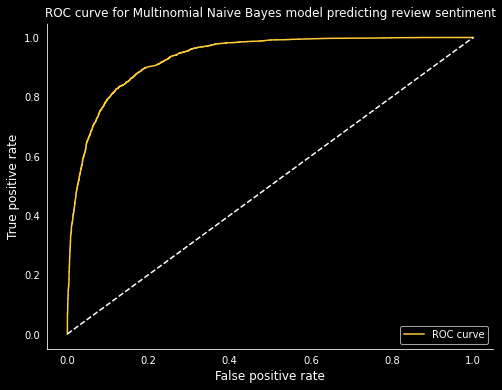



Confusion matrix: Logistic Regression 

 [[4729   36  415]
 [ 523   40  315]
 [ 488   45 3952]]


Classification report: Logistic Regression 

               precision    recall  f1-score   support

           0       0.82      0.91      0.87      5180
           1       0.33      0.05      0.08       878
           2       0.84      0.88      0.86      4485

    accuracy                           0.83     10543
   macro avg       0.67      0.61      0.60     10543
weighted avg       0.79      0.83      0.80     10543

AUC for Logistic Regression: 0.93941


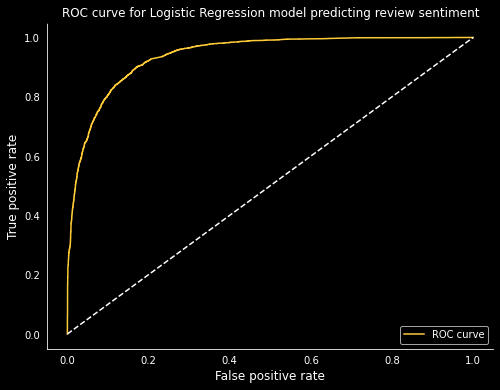



Confusion matrix: Random Forest 

 [[4728   20  432]
 [ 579   16  283]
 [ 728   20 3737]]


Classification report: Random Forest 

               precision    recall  f1-score   support

           0       0.78      0.91      0.84      5180
           1       0.29      0.02      0.03       878
           2       0.84      0.83      0.84      4485

    accuracy                           0.80     10543
   macro avg       0.64      0.59      0.57     10543
weighted avg       0.77      0.80      0.77     10543

AUC for Random Forest: 0.92099


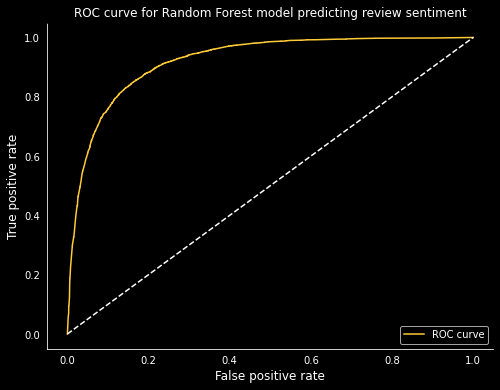

In [49]:
#loop iterates over each model, fits the data, creates predictions and outputs the results

model_list = [MultinomialNB(), LogisticRegression(random_state = 42), RandomForestClassifier(random_state = 42)]

model_name = ['Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest']

for model, name in zip(model_list, model_name):
    #fit the model
    model.fit(X_train, y_train)
    
    #create predictions
    model_preds = model.predict(X_valid)
    
    #create confusion matrix
    matrix = confusion_matrix(y_valid, model_preds)
    
    #print confusion matrix and classification report
    print('\n')
    
    #'\033[1m' prints in bold font
    print('\033[1m' + 'Confusion matrix:', name, '\n\n', matrix)
    
    print('\n')
    
    #We want to optimise recall for negative reviews (class 0) so that we 
    #can identify as many negative reviews as possible and respond accordingly
    print('\033[1m' + 'Classification report:', name, '\n\n', metrics.classification_report(y_valid, model_preds))
   
    #calculating probability scores to feed into the model
    prob_valid = model.predict_proba(X_valid)

    #keeping probabilities for 0 class outcome only (this is the negative reviews class which we're interested in)
    prob_valid_0 = prob_valid[:, 0]

    #calculate false positive rate (fpr), true positive rate (tpr) and thresholds
    #since this is multi-class, we have to add a pos_label to state which class we want to measure
    model_fpr, model_tpr, model_thresholds =  roc_curve(y_valid, prob_valid_0, pos_label = 0)    
    
    #calculating the AUC (area under curve) - this gives a single numeric metric to evaluate the model
    #an AUC value of 1 would represent a perfect classifier. If AUC = 0.5, the classifier only has 50% precision
    model_auc = auc(model_fpr, model_tpr)
    print('\033[1m' + 'AUC for ' + name + '\033[1m' + ':', round(model_auc, 5))
    
    #plotting an ROC (receiver operator characteristic) curve to evaluate the model performance visually - it illustrates 
    #the true positve rate against the false positve rate of the classifier. Best performing models will have an ROC curve 
    #that hugs the upper left corner of the graph. This would represent that we correctly classify the positive class more 
    #often than we incorrectly classify it. Smaller values on the x-axis of the plot indicate lower false positives and 
    #higher true negatives. Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

    fig = plt.figure(figsize = (8, 6))
    fig.set_facecolor('black')
    ax = plt.subplot()
    plt.plot(model_fpr, model_tpr, label = 'ROC curve', color = '#FFCB37')

    #plotting the diagonal line from zero which represents a model that guesses incorrectly for every correct guess
    plt.plot([0, 1], [0, 1], color = 'white', linestyle = 'dashed')

    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

    plt.legend(loc = 'lower right', facecolor = 'black', labelcolor = 'white')
    ax.patch.set_alpha(0.0)
    plt.xticks(color = 'white')
    plt.yticks(color = 'white')
    plt.xlabel('False positive rate', fontsize = 12, color = 'white')
    plt.ylabel('True positive rate', fontsize = 12, color = 'white')
    plt.title('ROC curve for ' + name + ' model predicting review sentiment', fontsize = 12, color = 'white')
    plt.show()

## Hyper-parameter tuning

In [50]:
#will now try to tune the hyper-parameters of the Logistic Regression and Random Forest models to see if this improves
#their result. Currently the Naive Bayes is performing best in terms of optimising recall for negative reviews

#create lists of hyperparameters for logistic regression

#penalty - penalises the model for having too many variables. This results in shrinking the coefficients of the less 
#contributive variables towards 0. This is also known as regularisation (default model uses l2)
penalty = ['l1', 'l2', 'elasticnet', 'none']

#C is the inverse of the strength of the penalty. C must be a positive float. A high value of C tells the model to give 
#high weight to the training data and a lower weight to the penalty. A low value of C tells the model to give more weight 
#to the penalty at the expense of fitting the training data. Default value of C is 1.0
C = [0.0001, 0.001, 0.1, 1.0, 10.0]

#solver is the algorithm that performs the regression. Default is lbfgs. Liblinear is better for smaller datasets and is
#not effectiv with multiclass probles so have excluded this as a solver
solver = ['newton-cg', 'lbfgs', 'sag', 'saga']

In [51]:
#now do the above for Random Forest

#number of trees, default is 100
n_estimators = [50, 100, 200, 400, 600]

#max number of features to consider at each split, default is sqrt
max_features = ['auto', 'sqrt']

#max number of levels in the tree, default is none
max_depth = [10, 20, 30, 40, 50]
max_depth.append(None)

#minimum number of samples required to split a node, default is 2
min_samples_split = [2, 5, 10]

#minimum number of samples required at each leaf node, default is 1
min_samples_leaf = [1, 2, 5]

#method of selecting samples for training each tree, default is True
bootstrap = [True, False]

In [54]:
#loop iterates over each model, fits the data and finds the best combination of hyper-parameters

model_list = [LogisticRegression(random_state = 42), RandomForestClassifier(random_state = 42)]

model_name = ['Logistic Regression', 'Random Forest']

#will use RandomizedSearchCV to evaluate each model. First need to set up a list of dictionaris of the hyperparameter values
grid_params = [{'penalty': penalty, 
                'C': C, 
                'solver': solver},
               
               {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}]

for model, name, params in zip(model_list, model_name, grid_params):
    
    #adding a start time as the following code will take a while to run
    start_time = time.time()
    
    #apply randomized grid search - this will test 30 logistic regression models and 30 random forest models
    model = RandomizedSearchCV(estimator = model, param_distributions = params, n_iter = 10, cv = 3)
    #fit the model
    model.fit(X_train, y_train)
    
    print('\n')
    
    #calculating end time
    print('\033[1m' + name + ' end time: %s minutes ' % round((time.time() - start_time) / 60, 2))
    
    print('\n')
    
    #check what the best combination of hyperparameters are
    print('\033[1m' + 'Best combination of hyper-parameters for ' + name + ':', model.best_params_)



Logistic Regression end time: 52.72 minutes 


Best combination of hyper-parameters for Logistic Regression: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 1.0}


Random Forest end time: 78.0 minutes 


Best combination of hyper-parameters for Random Forest: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}




Confusion matrix: Logistic Regression with hyper-parameter tuning 

 [[4736   28  416]
 [ 524   38  316]
 [ 494   41 3950]]


Classification report: Logistic Regression with hyper-parameter tuning 

               precision    recall  f1-score   support

           0       0.82      0.91      0.87      5180
           1       0.36      0.04      0.08       878
           2       0.84      0.88      0.86      4485

    accuracy                           0.83     10543
   macro avg       0.67      0.61      0.60     10543
weighted avg       0.79      0.83      0.80     10543

AUC for Logistic Regression with hyper-parameter tuning: 0.9392


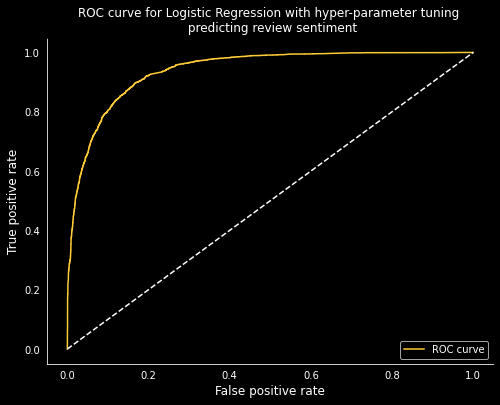



Confusion matrix: Random Forest with hyper-parameter tuning 

 [[4393    0  787]
 [ 531    0  347]
 [ 684    0 3801]]


Classification report: Random Forest with hyper-parameter tuning 

               precision    recall  f1-score   support

           0       0.78      0.85      0.81      5180
           1       0.00      0.00      0.00       878
           2       0.77      0.85      0.81      4485

    accuracy                           0.78     10543
   macro avg       0.52      0.57      0.54     10543
weighted avg       0.71      0.78      0.74     10543

AUC for Random Forest with hyper-parameter tuning: 0.89611


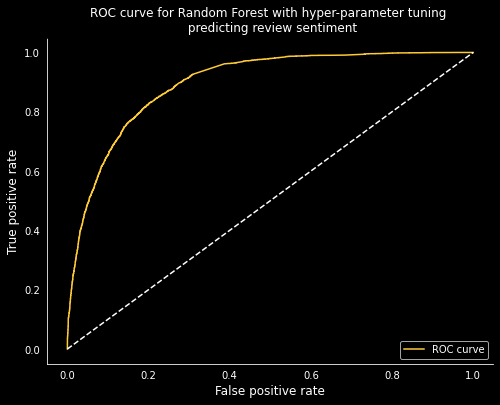

In [55]:
#fit the models with the optimal hyper-parameter combination

#loop iterates over each model, fits the data, creates predictions and outputs the results

model_list = [LogisticRegression(solver = 'newton-cg', penalty = 'l2', C = 1.0, random_state = 42), 
              RandomForestClassifier(n_estimators = 400, min_samples_split = 5, min_samples_leaf = 1, max_features = 'auto',\
                                     max_depth = 40, bootstrap = False, random_state = 42)]

model_name = ['Logistic Regression with hyper-parameter tuning', 'Random Forest with hyper-parameter tuning']

for model, name in zip(model_list, model_name):
    #fit the model
    model.fit(X_train, y_train)
    
    #create predictions
    model_preds = model.predict(X_valid)
    
    #create confusion matrix
    matrix = confusion_matrix(y_valid, model_preds)
    
    #print confusion matrix and classification report
    print('\n')
    
    #'\033[1m' prints in bold font
    print('\033[1m' + 'Confusion matrix:', name, '\n\n', matrix)
    
    print('\n')
    
    #We want to optimise recall for negative reviews (class 0) so that we 
    #can identify as many negative reviews as possible and respond accordingly
    print('\033[1m' + 'Classification report:', name, '\n\n', metrics.classification_report(y_valid, model_preds))
   
    #calculating probability scores to feed into the model
    prob_valid = model.predict_proba(X_valid)

    #keeping probabilities for 0 class outcome only (this is the negative reviews class which we're interested in)
    prob_valid_0 = prob_valid[:, 0]

    #calculate false positive rate (fpr), true positive rate (tpr) and thresholds
    #since this is multi-class, we have to add a pos_label to state which class we want to measure
    model_fpr, model_tpr, model_thresholds =  roc_curve(y_valid, prob_valid_0, pos_label = 0)    
    
    #calculating the AUC (area under curve)
    model_auc = auc(model_fpr, model_tpr)
    print('\033[1m' + 'AUC for ' + name + '\033[1m' + ':', round(model_auc, 5))
    
    #plotting an ROC curve
    fig = plt.figure(figsize = (8, 6))
    fig.set_facecolor('black')
    ax = plt.subplot()
    plt.plot(model_fpr, model_tpr, label = 'ROC curve', color = '#FFCB37')

    #plotting the diagonal line from zero which represents a model that guesses incorrectly for every correct guess
    plt.plot([0, 1], [0, 1], color = 'white', linestyle = 'dashed')

    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

    plt.legend(loc = 'lower right', facecolor = 'black', labelcolor = 'white')
    ax.patch.set_alpha(0.0)
    plt.xticks(color = 'white')
    plt.yticks(color = 'white')
    plt.xlabel('False positive rate', fontsize = 12, color = 'white')
    plt.ylabel('True positive rate', fontsize = 12, color = 'white')
    plt.title('ROC curve for ' + name + ' \n predicting review sentiment', fontsize = 12, color = 'white')
    plt.show()

## Fit best model on test data

In [56]:
#the model which optimised recall for the 0 class was the Multinomial Naive Bayes
# will fit this model to the test data

best_model = MultinomialNB()

best_model.fit(X_train, y_train)

best_preds = best_model.predict(X_test)

In [57]:
#create confusion matrix
best_matrix = confusion_matrix(y_test, best_preds)

print('\033[1m' + 'Confusion matrix:', '\n', best_matrix)    

Confusion matrix: 
 [[4885    1  401]
 [ 583    2  326]
 [ 687    0 3659]]


In [58]:
#print metrics - model has a high recall score of test data
print('\033[1m' + 'Classification report:', '\n', metrics.classification_report(y_test, best_preds))

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.92      0.85      5287
           1       0.67      0.00      0.00       911
           2       0.83      0.84      0.84      4346

    accuracy                           0.81     10544
   macro avg       0.76      0.59      0.57     10544
weighted avg       0.80      0.81      0.77     10544



In [59]:
#calculating probability scores to feed into the model
prob_test = best_model.predict_proba(X_test)

#keeping probabilities for 0 class outcome only (this is the negative reviews class which we're interested in)
prob_test_0 = prob_test[:, 0]

#calculate false positive rate (fpr), true positive rate (tpr) and thresholds
#since this is multi-class, we have to add a pos_label to state which class we want to measure
best_fpr, best_tpr, best_thresholds =  roc_curve(y_test, prob_test_0, pos_label = 0)    
    
#calculating the AUC (area under curve)
best_auc = auc(best_fpr, best_tpr)
print('\033[1m' + 'AUC for test data:', round(best_auc, 5))

AUC for test data: 0.92995


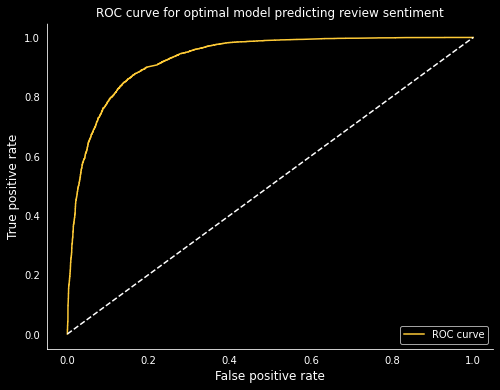

In [60]:
#plotting an ROC curve
fig = plt.figure(figsize = (8, 6))
fig.set_facecolor('black')
ax = plt.subplot()
plt.plot(best_fpr, best_tpr, label = 'ROC curve', color = '#FFCB37')

#plotting the diagonal line from zero which represents a model that guesses incorrectly for every correct guess
plt.plot([0, 1], [0, 1], color = 'white', linestyle = 'dashed')

ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

plt.legend(loc = 'lower right', facecolor = 'black', labelcolor = 'white')
ax.patch.set_alpha(0.0)
plt.xticks(color = 'white')
plt.yticks(color = 'white')
plt.xlabel('False positive rate', fontsize = 12, color = 'white')
plt.ylabel('True positive rate', fontsize = 12, color = 'white')
plt.title('ROC curve for optimal model predicting review sentiment', fontsize = 12, color = 'white')
plt.show()

In [61]:
#will draw out the final confusion matrix - first get the data labels

 #flatten puts the array values into one row
counts = ['{:,}'.format(value) for value in best_matrix.flatten()]
percentages = ['{0:.1%}'.format(value) for value in best_matrix.flatten() / np.sum(best_matrix)]

#the below attaches the above information together
labels = [f'{a} \n {b}' for a, b, in zip(counts, percentages)]

#converting the above into an array
labels_array = np.asarray(labels).reshape(3, 3)

In [62]:
#stats to display below the matrix - these are the stats for negative reviews (class 0)

#np.trace() sums the diagonals of the matrix from left to right
accuracy = np.trace(best_matrix) / np.sum(best_matrix)

#[0, 0] is the top left corner - true positives for negative reviews, [:, 0] is the first column - all predicted positives
precision = best_matrix[0, 0] / sum(best_matrix[:, 0])

#[0, :] is the top row - predicted false negatives plus true positives
recall = best_matrix[0, 0] / sum(best_matrix [0, :])

f1_score = 2 * precision * recall / (precision + recall)

text = '\n\n\n Accuracy = {:0.3f} \n Precision = {:0.3f} \n Recall = {:0.3f} \n F1 score = {:0.3f}'.format(accuracy, 
                                                                                            precision, recall, f1_score)

Text(0.5, 1.0, 'Confusion matrix for test data')

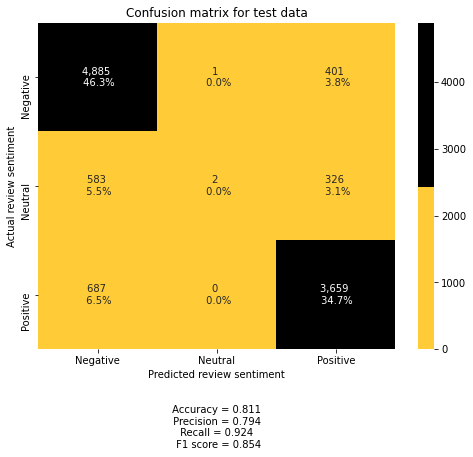

In [63]:
#creating the matrices
fig = plt.figure(figsize = (8, 6))

ax = plt.subplot()
matrix_colours = ['#FFCB37', '#000000']
matrix_cmap = LinearSegmentedColormap.from_list('Custom', matrix_colours, len(matrix_colours))

colours = sns.color_palette("rocket")

#fmt allows for string annotations on the heat map - annot only allows for numerical 
sns.heatmap(best_matrix, annot = labels_array, fmt = '', cmap = matrix_colours, cbar = True)

ax.set_xlabel('Predicted review sentiment' + text)
ax.set_ylabel('Actual review sentiment')

ax.xaxis.set_ticklabels(['Negative','Neutral', 'Positive'])
ax.yaxis.set_ticklabels(['Negative','Neutral', 'Positive'])

ax.set_title('Confusion matrix for test data')       

## Results

- **Following model training, the Multinomial Naive Bayes model performed best at correctly identifying negative reviews.** 
- **The model can be used to identify negative reviews faster, solve customer problems and increase customer satisfaction.**  